<h1><b><center>CLASIFICACIÓN DE NORMALIDAD EN TEJIDO DE MAMAS A PARTIR DE IMÁGENES DIGITALES DE RAYOS X</center></h1>

|<h2><font color='white'>-----------------------</font><b>DIEGO FERNANDO VELASCO GIRALDO||
|---|---|
|||
|||
| <left><font size="4">Estudiante de Maestría en Ingeniería con Énfasis en Ingeniería Electrónica</font> | <center><img src="https://drive.google.com/uc?id=1CtdK5Litx2pQmTGD3U2Qs0MxIVs_nB8H" width="55" height="80" /> |
|||
| <left><font size="4">Grupo de Investigación Percepción y Sistemas Inteligentes - Univalle</font> | <center><img src="https://drive.google.com/uc?id=1qEQd1k3SOIeLx-X0OSYQ0DosajsIy9Vc" width="165" height="70" /> |
|||
| <left><i><font size="4">Correo Electrónico: diego.fernando.velasco@correounivalle.edu.co</font></i> | <center><i><font size="4">Celular: 3234777477</font></i> |
|||

<center><h4><i>Proyecto de Grado - Modalidad: Profundización - Universidad del Valle - Director: Humberto Loaiza, Ph.D.</i></h4>
<br>

## Librerías necesarias

In [ ]:
# import the necessary packages
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import random
#import argparse
import cv2
import glob
import os
import shutil
from pandas import DataFrame
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.feature import local_binary_pattern
from scipy.stats import entropy
import math

## Montaje drive de Google y verificación de GPU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Implementación Proyecto Grado Maestría

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Mounted at /content/drive
/content/drive/MyDrive/Implementación Proyecto Grado Maestría
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


## Carga y data wrangling de metadatos del mini-MIAS dataset

In [ ]:
dataPath = "all-mias"
nn_svm_new_folder = '/nn_svm_new_9-11'

textFile = os.path.join(dataPath,"miasInfo.txt")
mias_df = pd.read_csv(textFile, sep=" ", header=0)
mias_df.head(3)

#values = {"SEVERITY": 'N', "X": 0, "Y": 0, "RADIUS": 0}
#mias_df = mias_df.fillna(value=values)
#mias_df.head(3)

#mias_df.X = mias_df.X.astype(int)
#mias_df.Y = mias_df.Y.astype(int)
#mias_df.RADIUS = mias_df.RADIUS.astype(int)
#mias_df.head(3)

#mias_df.loc[mias_df["SEVERITY"] !='N', "SEVERITY"] = 'A'
#mias_df.head(3)
#print(mias_df)

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN


In [ ]:
values = {"SEVERITY": 'N', "X": 0, "Y": 0, "RADIUS": 0}
mias_df = mias_df.fillna(value=values)
mias_df.head(3)

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,N,0.0,0.0,0.0


In [ ]:
print(mias_df.shape)
mias_df_uniques = mias_df.drop_duplicates(subset = ["REFNUM"])
benign_uniques = mias_df_uniques[mias_df_uniques.SEVERITY=='B']
malignant_uniques = mias_df_uniques[mias_df_uniques.SEVERITY=='M']
normal_uniques = mias_df_uniques[mias_df_uniques.SEVERITY=='N']
print("Number of benign images: ", benign_uniques.shape)
print("Number of malignant images: ", malignant_uniques.shape)
print("Number of normal images: ",normal_uniques.shape)

(330, 7)
Number of benign images:  (62, 7)
Number of malignant images:  (51, 7)
Number of normal images:  (209, 7)


In [ ]:
mias_df.loc[mias_df["SEVERITY"] !='N', "SEVERITY"] = 'A'
mias_df.head(3)

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,A,535.0,425.0,197.0
1,mdb002,G,CIRC,A,522.0,280.0,69.0
2,mdb003,D,NORM,N,0.0,0.0,0.0


In [ ]:
mias_df.X = mias_df.X.astype(int)
mias_df.Y = mias_df.Y.astype(int)
mias_df.RADIUS = mias_df.RADIUS.astype(int)
#mias_df.head(3)
print(mias_df)

     REFNUM BG CLASS SEVERITY    X    Y  RADIUS
0    mdb001  G  CIRC        A  535  425     197
1    mdb002  G  CIRC        A  522  280      69
2    mdb003  D  NORM        N    0    0       0
3    mdb004  D  NORM        N    0    0       0
4    mdb005  F  CIRC        A  477  133      30
..      ... ..   ...      ...  ...  ...     ...
325  mdb318  D  NORM        N    0    0       0
326  mdb319  D  NORM        N    0    0       0
327  mdb320  D  NORM        N    0    0       0
328  mdb321  D  NORM        N    0    0       0
329  mdb322  D  NORM        N    0    0       0

[330 rows x 7 columns]


In [ ]:
mias_df_new = mias_df.drop(mias_df[(mias_df['SEVERITY'] == 'A') & (mias_df['RADIUS'] == 0)].index)
print(mias_df_new)

print('\nAbnormal with no X, Y labeled: \n', mias_df[(mias_df['SEVERITY'] == 'A') & (mias_df['RADIUS'] == 0)])

print("\nLabeled abnormalities (more than one in some images) and labeled as normal: ", mias_df_new.shape)

#Split by class:
abnormalClass = mias_df_new[mias_df_new.SEVERITY=='A']
print("Labeled as abnormal: ", abnormalClass.shape)
normalClass = mias_df_new[mias_df_new.SEVERITY=='N']
print("Labeled as normal: ", normalClass.shape)

#Unique REFNUM:
mias_df_uniques = mias_df_new.drop_duplicates(subset = ["REFNUM"]) #REFNUM únicos porque se repiten para número de imgs no de anormalidades presentes
abnormal_uniques = mias_df_uniques[mias_df_uniques.SEVERITY=='A']
normal_uniques = mias_df_uniques[mias_df_uniques.SEVERITY=='N']
print("\nNumber of images: ", mias_df_uniques.shape)
print("Number of abnormal images: ", abnormal_uniques.shape)
print("Number of normal images: ", normal_uniques.shape)

     REFNUM BG CLASS SEVERITY    X    Y  RADIUS
0    mdb001  G  CIRC        A  535  425     197
1    mdb002  G  CIRC        A  522  280      69
2    mdb003  D  NORM        N    0    0       0
3    mdb004  D  NORM        N    0    0       0
4    mdb005  F  CIRC        A  477  133      30
..      ... ..   ...      ...  ...  ...     ...
325  mdb318  D  NORM        N    0    0       0
326  mdb319  D  NORM        N    0    0       0
327  mdb320  D  NORM        N    0    0       0
328  mdb321  D  NORM        N    0    0       0
329  mdb322  D  NORM        N    0    0       0

[326 rows x 7 columns]

Abnormal with no X, Y labeled: 
      REFNUM BG CLASS SEVERITY  X  Y  RADIUS
59   mdb059  F  CIRC        A  0  0       0
218  mdb216  D  CALC        A  0  0       0
238  mdb233  G  CALC        A  0  0       0
251  mdb245  F  CALC        A  0  0       0

Labeled abnormalities (more than one in some images) and labeled as normal:  (326, 7)
Labeled as abnormal:  (117, 7)
Labeled as normal:  (209, 7)

In [ ]:
print('Max values of RADIUS column')
maxValues = mias_df_new['RADIUS'].max()
print(maxValues)

mias_df_new_2 = mias_df_new.drop(mias_df_new[(mias_df_new['RADIUS'] == 0)].index)
#print(mias_df_new_2)
print('\nMin values of RADIUS column')
minValues = mias_df_new_2['RADIUS'].min()
print(minValues)

#128 o 256 tocaría tamaño de ventanas

Max values of RADIUS column
197

Min values of RADIUS column
6


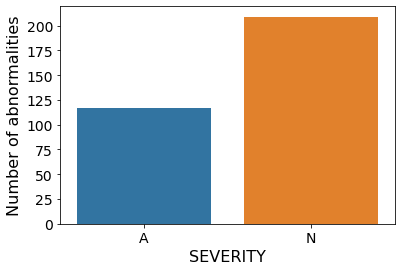

In [ ]:
ax = sns.countplot(x="SEVERITY", data=mias_df_new)
ax.set_xlabel("SEVERITY",fontsize=16)
ax.set_ylabel("Number of abnormalities",fontsize=16)
plt.xticks(size = 14)
plt.yticks(size = 14)
# plt.grid(False)
plt.show()

## Copia de imágenes correspondientes a carpetas normal y anormal

In [ ]:
dataPath01 = dataPath + nn_svm_new_folder
if os.path.isdir(dataPath01) is False:
  os.mkdir(dataPath01)

orig_path = dataPath+'/allmias_PNG_mat_eq/'
comp_name = '_output.png'

abnormal_fileNames = abnormalClass.REFNUM
normal_fileNames = normalClass.REFNUM

abnormal_train_path = dataPath01+'/train/abnormal/'
normal_train_path = dataPath01+'/train/normal/'

if os.path.isdir(abnormal_train_path) is False:
    os.makedirs(abnormal_train_path)
    os.makedirs(normal_train_path)

    for image_name in abnormal_fileNames:
        #shutil.copy(dataPath+'/all-miasPythonProcessed/'+image_name+'_processed.png', benign_processed_path)
        shutil.copy(orig_path + image_name + comp_name, abnormal_train_path)

    for image_name in normal_fileNames:
        #shutil.copy(dataPath+'/all-miasPythonProcessed/'+image_name+'_processed.png', normal_processed_path)
        shutil.copy(orig_path + image_name + comp_name, normal_train_path)

## Extracción de patches de anormalidades
Se extraen patches de las anormalidades utilizando las coordenadas X, Y y radio suministradas en los metadatos

In [ ]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [ ]:
#Saco patches de las anormales:

#abnormal_path = dataPath01+'/abnormal/'
abnormal_images = glob.glob(abnormal_train_path+'*.png')
abnormal_images = sorted(abnormal_images)

ab_patches_train_path = (dataPath01+'/train/abnormal_patches/')

if os.path.isdir(ab_patches_train_path) is False:
  os.mkdir(ab_patches_train_path)

  patches = []
  patches_names = []
  color = 255

  stepSize = 8
  winH = 64
  winW = 64
  windowSize = (winH, winW)

  for file_path in abnormal_images:
      image = cv2.imread(file_path,0)
      basename = os.path.basename(file_path)  # e.g. MyPhoto.jpg
      name = os.path.splitext(basename)[0]  # e.g. MyPhoto
      name = name[:6]
      roi_df = mias_df_new.loc[mias_df_new['REFNUM'] == name, ['X', 'Y', 'RADIUS']]
      roi_values = roi_df.values
      height, width = image.shape[:2] #height, width, without number of channels
      #for row, i in zip(roi_values, range(len(roi_values))):
      i=0
      for row in (roi_values):
          zeros_image = np.zeros(image.shape[:2], np.uint8)
          i=i+1
          X, Y, RADIUS = row
          Y_new = height - Y
          if RADIUS <= 32:
            mask = cv2.rectangle(zeros_image, (X-32, Y_new+32), (X+32, Y_new-32), color, cv2.FILLED)
            x, y = np.nonzero(mask)
            xl,xr = x.min(),x.max()
            yl,yr = y.min(),y.max()
            cropped_img = image[xl:xr, yl:yr]
            patches.append(cropped_img)
            if (len(roi_values) == 1):
              patches_names.append(name+'_patch')
            else:
              patches_names.append(name+'_patch'+str(i))
          else:
            diameter = (RADIUS*2)
            modulo_8 = diameter%8
            if modulo_8 != 0:
              diameter = diameter + (8 - modulo_8)
              RADIUS = diameter//2
              #print(X, Y_new)
              #print(RADIUS)
              mask = cv2.rectangle(zeros_image, (X-RADIUS, Y_new+RADIUS), (X+RADIUS, Y_new-RADIUS), color, cv2.FILLED)
              x, y = np.nonzero(mask)
              xl,xr = x.min(),x.max()
              yl,yr = y.min(),y.max()
              cropped_img = image[xl:xr, yl:yr]
              # Lo de aquí en frente va con 64x64
              j=0
              for (x, y, window) in sliding_window(cropped_img, stepSize, windowSize):
                # if the current window does not meet our desired window size, ignore it
                j=j+1;
                if window.shape[0] != winH or window.shape[1] != winW:
                  continue
                # PROCESS WINDOW, EXTRACT FEATURES
                window = cropped_img[y:y + windowSize[1], x:x + windowSize[0]]
                patches.append(window)
                if (len(roi_values) == 1):
                  patches_names.append(name+'_patch'+str(j))
                else:
                  patches_names.append(name+'_patch'+str(i)+'_'+str(j))
                #patches_names.append(name+'_patch'+str(j))
            else:
              #print(X, Y_new)
              #print(RADIUS)
              mask = cv2.rectangle(zeros_image, (X-RADIUS, Y_new+RADIUS), (X+RADIUS, Y_new-RADIUS), color, cv2.FILLED)
              x, y = np.nonzero(mask)
              xl,xr = x.min(),x.max()
              yl,yr = y.min(),y.max()
              cropped_img = image[xl:xr, yl:yr]
              # Lo de aquí en frente va con 64x64
              j=0
              for (x, y, window) in sliding_window(cropped_img, stepSize, windowSize):
                # if the current window does not meet our desired window size, ignore it
                j=j+1;
                if window.shape[0] != winH or window.shape[1] != winW:
                  continue
                # PROCESS WINDOW, EXTRACT FEATURES
                window = cropped_img[y:y + windowSize[1], x:x + windowSize[0]]
                patches.append(window)
                if (len(roi_values) == 1):
                  patches_names.append(name+'_patch'+str(j))
                else:
                  patches_names.append(name+'_patch'+str(i)+'_'+str(j))
                #patches_names.append(name+'_patch'+str(j))
                #cv2.rectangle(clone2, (x, y), (x + winW, y + winH), (255,0,0), 2)
              #
  print(len(patches))

  for patch, patch_name in zip(patches, patches_names):
      cv2.imwrite((ab_patches_train_path + patch_name + '.png'), patch)

In [ ]:
def Repeat(x):
    _size = len(x)
    repeated = []
    for i in range(_size):
        k = i + 1
        for j in range(k, _size):
            if x[i] == x[j] and x[i] not in repeated:
                repeated.append(x[i])
    return repeated

print(Repeat(patches_names))
print(len(Repeat(patches_names)))


print(len(patches_names))
print(len(patches))
print(len(os.listdir(ab_patches_train_path))) #imprimir cantidad de archivos de carpeta

NameError: ignored

## Extracción de patches de mamas normales
Se extraen patches aleatorios de la misma dimensión de los anteriores, pero de las mamas normales.

In [ ]:
#Saco patches de las normales:

#normal_path = dataPath01+'/normal/'
normal_images = glob.glob(normal_train_path+'*.png')
normal_images = sorted(normal_images)

nor_patches_train_path = (dataPath01+'/train/normal_patches/')

if os.path.isdir(nor_patches_train_path) is False:
  os.mkdir(nor_patches_train_path)

  patches = []
  patches_names = []

  color = 255

  for file_path in normal_images:
      image = cv2.imread(file_path,0)
      basename = os.path.basename(file_path)  # e.g. MyPhoto.jpg
      name = os.path.splitext(basename)[0]  # e.g. MyPhoto
      name = name[:6]
      for i in range(57):
          zeros_image = np.zeros(image.shape[:2], np.uint8)
          i=i+1
          X = random.randint(256,768)
          Y = random.randint(256,768)
          mask = cv2.rectangle(zeros_image, (X, Y), (X+64, Y-64), color, cv2.FILLED)
          x, y = np.nonzero(mask)
          xl,xr = x.min(),x.max()
          yl,yr = y.min(),y.max()
          cropped_img = image[xl:xr, yl:yr]
          #cropped_img = cv2.resize(cropped_img, (64,64))
          patches.append(cropped_img)
          patches_names.append(name+'_patch'+str(i))

  print(len(patches))

  for patch, patch_name in zip(patches, patches_names):
      cv2.imwrite((nor_patches_train_path + patch_name + '.png'), patch)

In [ ]:
def remove_surplus(nor_patches_train_path, ab_patches_train_path):
  a = len(os.listdir(nor_patches_train_path))
  b = len(os.listdir(ab_patches_train_path))
  if  a > b:
    dif = a - b
    for c in random.sample(glob.glob(nor_patches_train_path+'*.png'), dif):
      os.remove(c) #Elimino las sobrantes para que quede la misma cantidad de imágenes que en /abnormal_processed

print('Antes de remove surplus:')
print(len(os.listdir(ab_patches_train_path))) #imprimir cantidad de archivos de carpeta
print(len(os.listdir(nor_patches_train_path))) #imprimir cantidad de archivos de carpeta

remove_surplus(nor_patches_train_path, ab_patches_train_path)

print('\nDespués de remove surplus:')
print(len(os.listdir(ab_patches_train_path))) #imprimir cantidad de archivos de carpeta
print(len(os.listdir(nor_patches_train_path))) #imprimir cantidad de archivos de carpeta

Antes de remove surplus:
10041
10041

Después de remove surplus:
10041
10041


## Movimiento de 15% de las imágenes en abnormal y normal a carpetas de test, porque se sacará otro 15% de las de train durante el entrenamiento para validation

In [ ]:
ab_patches_test_path = dataPath01+'/test/abnormal_patches/'
nor_patches_test_path = dataPath01+'/test/normal_patches/'

if os.path.isdir(ab_patches_test_path) is False:
  os.makedirs(ab_patches_test_path)
  os.makedirs(nor_patches_test_path)

  train_abnorm_imgs = glob.glob(ab_patches_train_path+'*.png')
  train_norm_imgs = glob.glob(nor_patches_train_path+'*.png')

  test_abnorm_imgs = random.sample(train_abnorm_imgs, 1771) #aprox. 15% de las imágenes para test.
  test_norm_imgs = random.sample(train_norm_imgs, 1771)

  for test_image in test_abnorm_imgs:
      shutil.move(test_image, ab_patches_test_path)

  for test_image in test_norm_imgs:
      shutil.move(test_image, nor_patches_test_path)

## Creación de listas de patches y sus nombres para train y test

In [ ]:
def patches_names_lists(ab_patches_path, nor_patches_path):
    abnormal_patches = glob.glob(ab_patches_path+'*.png')
    abnormal_patches = sorted(abnormal_patches)

    normal_patches = glob.glob(nor_patches_path+'*.png')
    normal_patches = sorted(normal_patches)

    abnormal_patches_lst = []
    normal_patches_lst = []
    abnormal_patches_names = []
    normal_patches_names = []

    for abnormal_patch  in abnormal_patches:
        abnormal_patch_im = cv2.imread(abnormal_patch, 0)
        abnormal_patches_lst.append(abnormal_patch_im)

        basename_ab = os.path.basename(abnormal_patch)
        name_ab = basename_ab[basename_ab.find("mdb"):basename_ab.find("mdb")+6]
        abnormal_patches_names.append(name_ab)

    for normal_patch in normal_patches:
        normal_patch_im = cv2.imread(normal_patch, 0)
        normal_patches_lst.append(normal_patch_im)

        basename_n = os.path.basename(normal_patch)
        name_n = basename_n[basename_n.find("mdb"):basename_n.find("mdb")+6]
        normal_patches_names.append(name_n)

    return abnormal_patches_lst, normal_patches_lst, abnormal_patches_names, normal_patches_names

In [ ]:
#ab_train_patches_lst, nor_train_patches_lst, ab_train_patches_names, nor_train_patches_names = patches_names_lists(ab_patches_train_path, nor_patches_train_path)

#ab_test_patches_lst, nor_test_patches_lst, ab_test_patches_names, nor_test_patches_names = patches_names_lists(ab_patches_test_path, nor_patches_test_path)

#print(len(ab_test_patches_names))
#print(len(nor_test_patches_names))

In [ ]:
'''
import pickle

with open("ab_train_patches_lst_file.pkl", "wb") as fp:
  pickle.dump(ab_train_patches_lst, fp)
with open("nor_train_patches_lst_file.pkl", "wb") as fp:
  pickle.dump(nor_train_patches_lst, fp)
with open("ab_train_patches_names_file.pkl", "wb") as fp:
  pickle.dump(ab_train_patches_names, fp)
with open("nor_train_patches_names_file.pkl", "wb") as fp:
  pickle.dump(nor_train_patches_names, fp)

with open("ab_test_patches_lst_file.pkl", "wb") as fp:
  pickle.dump(ab_test_patches_lst, fp)
with open("nor_test_patches_lst_file.pkl", "wb") as fp:
  pickle.dump(nor_test_patches_lst, fp)
with open("ab_test_patches_names_file.pkl", "wb") as fp:
  pickle.dump(ab_test_patches_names, fp)
with open("nor_test_patches_names_file.pkl", "wb") as fp:
  pickle.dump(nor_test_patches_names, fp)
'''

In [ ]:
import pickle

with open("ab_train_patches_lst_file.pkl", "rb") as fp:
  ab_train_patches_lst_r = pickle.load(fp)
with open("nor_train_patches_lst_file.pkl", "rb") as fp:
  nor_train_patches_lst_r = pickle.load(fp)
with open("ab_train_patches_names_file.pkl", "rb") as fp:
  ab_train_patches_names_r = pickle.load(fp)
with open("nor_train_patches_names_file.pkl", "rb") as fp:
  nor_train_patches_names_r = pickle.load(fp)

with open("ab_test_patches_lst_file.pkl", "rb") as fp:
  ab_test_patches_lst_r = pickle.load(fp)
with open("nor_test_patches_lst_file.pkl", "rb") as fp:
  nor_test_patches_lst_r = pickle.load(fp)
with open("ab_test_patches_names_file.pkl", "rb") as fp:
  ab_test_patches_names_r = pickle.load(fp)
with open("nor_test_patches_names_file.pkl", "rb") as fp:
  nor_test_patches_names_r = pickle.load(fp)

In [ ]:
print(len(ab_train_patches_names_r))
print(len(nor_train_patches_names_r))
print(len(ab_test_patches_names_r))
print(len(nor_test_patches_names_r))

10041
10041
1771
1771


## Funciones para extracción de características desde la matriz de co-ocurrencia de niveles de gris (GLCM)

In [ ]:
from skimage.feature import greycomatrix, greycoprops

def get_textural_features(img):
    #img = img_as_ubyte(rgb2gray(img))
    glcm = greycomatrix(img, [1], [0], 256, symmetric=True, normed=True)
    dissimilarity = greycoprops(glcm, 'dissimilarity')[0, 0]
    correlation = greycoprops(glcm, 'correlation')[0, 0]
    homogeneity = greycoprops(glcm, 'homogeneity')[0, 0]
    energy = greycoprops(glcm, 'energy')[0, 0]
    features = [dissimilarity, correlation, homogeneity, energy]
    return features

In [ ]:
def extract_features_one_image(image):
    METHOD = 'default'
    radius = 1 #Solo cambio este valor (1 el mejor hasta ahora)
    n_points = 8 * radius
    matplotlib.rcParams['font.size'] = 9
    np.seterr(invalid='ignore')
    hist = cv2.calcHist([image], [0], None, [251], [5, 256])
    lbp = local_binary_pattern(image, n_points, radius, METHOD)
    lbp = np.array(lbp, dtype=np.uint8)
    lbp_neg = cv2.bitwise_not(lbp)
    lbp_hist = cv2.calcHist([lbp_neg],[0],None,[251],[5,256])
    entropy_im_hist = float(entropy(hist))
    if math.isnan(entropy_im_hist): entropy_im_hist = 0.0
    entropy_lbp_hist = float(entropy(lbp_hist))
    if math.isnan(entropy_lbp_hist): entropy_lbp_hist = 0.0
    data_1 = [float(np.mean(hist)), float(np.median(hist)), entropy_im_hist,
              float(np.mean(lbp_hist)), float(np.median(lbp_hist)), entropy_lbp_hist]
    data_2 = get_textural_features(image)
    data_3 = get_textural_features(lbp_neg)
    stats_data = [*data_1, *data_2, *data_3]
    #stats_data_df = pd.DataFrame(stats_data)
    return stats_data

In [ ]:
def extract_features(patches_lst, patches_names, stats_df):
    METHOD = 'default'
    radius = 1 #Solo cambio este valor (1 el mejor hasta ahora)
    n_points = 8 * radius
    matplotlib.rcParams['font.size'] = 9
    np.seterr(invalid='ignore')

    for image, name in zip(patches_lst, patches_names):
        hist = cv2.calcHist([image], [0], None, [251], [5, 256])
        lbp = local_binary_pattern(image, n_points, radius, METHOD)
        lbp = np.array(lbp, dtype=np.uint8)
        lbp_neg = cv2.bitwise_not(lbp)
        lbp_hist = cv2.calcHist([lbp_neg],[0],None,[251],[5,256])
        df_1 = mias_df_new[mias_df_new['REFNUM'] == name]#.SEVERITY.item()
        data_1 = df_1[['REFNUM', 'SEVERITY']].values.flatten().tolist()
        data_1 = [data_1[0], data_1[1]]
        #data_2 = [float(np.mean(hist)), float(np.std(hist)), float(skew(hist)), float(kurtosis(hist)), float(entropy(hist)),
        #          float(np.mean(lbp_hist)), float(np.std(lbp_hist)), float(skew(lbp_hist)), float(kurtosis(lbp_hist)), float(entropy(lbp_hist))]
        entropy_im_hist = float(entropy(hist))
        if math.isnan(entropy_im_hist): entropy_im_hist = 0.0
        entropy_lbp_hist = float(entropy(lbp_hist))
        if math.isnan(entropy_lbp_hist): entropy_lbp_hist = 0.0
        data_2 = [float(np.mean(hist)), float(np.median(hist)), entropy_im_hist,
                  float(np.mean(lbp_hist)), float(np.median(lbp_hist)), entropy_lbp_hist]
        #data_2 = [float(np.mean(lbp_hist)), float(np.std(lbp_hist)), float(skew(lbp_hist)), float(kurtosis(lbp_hist)), float(entropy(lbp_hist))]
        data_3 = get_textural_features(image)
        data_4 = get_textural_features(lbp_neg)
        stats_data = [*data_1, *data_2, *data_3, *data_4]
        #print(stats_data)
        stats_df.loc[len(stats_df)] = stats_data

In [ ]:
columns = ['REFNUM', 'SEVERITY', 'HIST_MEAN', 'HIST_MEDIAN', 'HIST_ENTROPY', 'LBP_HIST_MEAN', 'LBP_HIST_MEDIAN', 'LBP_HIST_ENTROPY',
             'DISSIMILARITY', 'CORRELATION', 'HOMOGENEITY', 'ENERGY', 'LBP_DISSIMILARITY', 'LBP_CORRELATION', 'LBP_HOMOGENEITY', 'LBP_ENERGY']
stats_df_train = pd.DataFrame(columns = columns)

#np.seterr(divide='ignore', invalid='ignore')
np.seterr(invalid='ignore')
extract_features(ab_train_patches_lst_r, ab_train_patches_names_r, stats_df_train)
extract_features(nor_train_patches_lst_r, nor_train_patches_names_r, stats_df_train)

stats_df_train.head(3) #display(stats_df_train)
#print(stats_df_train.isnull().sum().sum())

,REFNUM,SEVERITY,HIST_MEAN,HIST_MEDIAN,HIST_ENTROPY,LBP_HIST_MEAN,LBP_HIST_MEDIAN,LBP_HIST_ENTROPY,DISSIMILARITY,CORRELATION,HOMOGENEITY,ENERGY,LBP_DISSIMILARITY,LBP_CORRELATION,LBP_HOMOGENEITY,LBP_ENERGY
0,mdb001,A,16.318726,16.0,4.994142,14.609562,2.0,3.838340,3.224950,0.995065,0.280218,0.027608,74.773065,0.196317,0.114168,0.063133
1,mdb001,A,16.318726,1.0,4.602954,14.350597,2.0,4.045082,2.149306,0.994449,0.370214,0.039630,79.975942,0.253242,0.101699,0.048213
2,mdb001,A,16.318726,1.0,4.560299,14.649403,2.0,4.040492,2.092014,0.994960,0.376416,0.041931,72.892857,0.322084,0.115624,0.048002


In [ ]:
columns = ['REFNUM', 'SEVERITY', 'HIST_MEAN', 'HIST_MEDIAN', 'HIST_ENTROPY', 'LBP_HIST_MEAN', 'LBP_HIST_MEDIAN', 'LBP_HIST_ENTROPY',
             'DISSIMILARITY', 'CORRELATION', 'HOMOGENEITY', 'ENERGY', 'LBP_DISSIMILARITY', 'LBP_CORRELATION', 'LBP_HOMOGENEITY', 'LBP_ENERGY']
stats_df_test = pd.DataFrame(columns = columns)

extract_features(ab_test_patches_lst_r, ab_test_patches_names_r, stats_df_test)
extract_features(nor_test_patches_lst_r, nor_test_patches_names_r, stats_df_test)

stats_df_test.head(3) #display(stats_df_test)
#print(stats_df_test.isnull().sum().sum())

,REFNUM,SEVERITY,HIST_MEAN,HIST_MEDIAN,HIST_ENTROPY,LBP_HIST_MEAN,LBP_HIST_MEDIAN,LBP_HIST_ENTROPY,DISSIMILARITY,CORRELATION,HOMOGENEITY,ENERGY,LBP_DISSIMILARITY,LBP_CORRELATION,LBP_HOMOGENEITY,LBP_ENERGY
0,mdb001,A,15.641435,0.0,3.973188,11.980080,1.0,3.920410,2.048115,0.983118,0.410796,0.059439,99.500496,-0.027703,0.076777,0.089249
1,mdb001,A,16.318726,3.0,4.576618,14.597610,2.0,4.030899,2.060020,0.994948,0.376491,0.041494,76.254464,0.288191,0.106244,0.047656
2,mdb001,A,16.318726,14.0,4.897147,14.231075,3.0,4.271212,4.985615,0.983202,0.221210,0.024961,78.070685,0.292628,0.094024,0.037360


In [ ]:
#Split features and labels:
features_train = stats_df_train.drop(['REFNUM', 'SEVERITY'],axis=1)
labels_train = stats_df_train.SEVERITY
#labels_train.replace({'A': 0, 'N': 1}, inplace=True)

display(features_train)
display(labels_train)

#print(features)
#print(labels)

,HIST_MEAN,HIST_MEDIAN,HIST_ENTROPY,LBP_HIST_MEAN,LBP_HIST_MEDIAN,LBP_HIST_ENTROPY,DISSIMILARITY,CORRELATION,HOMOGENEITY,ENERGY,LBP_DISSIMILARITY,LBP_CORRELATION,LBP_HOMOGENEITY,LBP_ENERGY
0,16.318726,16.0,4.994142,14.609562,2.0,3.838340,3.224950,0.995065,0.280218,0.027608,74.773065,0.196317,0.114168,0.063133
1,16.318726,1.0,4.602954,14.350597,2.0,4.045082,2.149306,0.994449,0.370214,0.039630,79.975942,0.253242,0.101699,0.048213
2,16.318726,1.0,4.560299,14.649403,2.0,4.040492,2.092014,0.994960,0.376416,0.041931,72.892857,0.322084,0.115624,0.048002
3,16.318726,0.0,4.597825,14.661355,2.0,4.080722,2.268105,0.993389,0.365461,0.040336,70.997024,0.342125,0.118997,0.047168
4,16.318726,0.0,4.614349,14.581674,2.0,4.114615,2.580605,0.991189,0.352568,0.038777,69.469990,0.364736,0.122165,0.046307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20077,16.318726,0.0,4.604300,14.175299,3.0,4.325130,4.420139,0.977628,0.205617,0.027005,83.386905,0.297778,0.083605,0.037040
20078,16.318726,0.0,4.632746,14.254980,2.0,4.326636,4.906746,0.972844,0.187392,0.025053,80.010417,0.329130,0.095979,0.037731
20079,16.318726,0.0,4.494663,14.035856,3.0,4.362547,4.349206,0.971951,0.263360,0.037031,87.542659,0.247587,0.081344,0.034110
20080,15.298805,0.0,3.288977,9.597610,0.0,3.300759,1.917659,0.983523,0.517661,0.191533,95.987847,0.033665,0.200641,0.203201


0        A
1        A
2        A
3        A
4        A
        ..
20077    N
20078    N
20079    N
20080    N
20081    N
Name: SEVERITY, Length: 20082, dtype: object

In [ ]:
features_test = stats_df_test.drop(['REFNUM', 'SEVERITY'],axis=1)
labels_test = stats_df_test.SEVERITY
#labels_test.replace({'A': 0, 'N': 1}, inplace=True)

display(features_test)
display(labels_test)

,HIST_MEAN,HIST_MEDIAN,HIST_ENTROPY,LBP_HIST_MEAN,LBP_HIST_MEDIAN,LBP_HIST_ENTROPY,DISSIMILARITY,CORRELATION,HOMOGENEITY,ENERGY,LBP_DISSIMILARITY,LBP_CORRELATION,LBP_HOMOGENEITY,LBP_ENERGY
0,15.641435,0.0,3.973188,11.980080,1.0,3.920410,2.048115,0.983118,0.410796,0.059439,99.500496,-0.027703,0.076777,0.089249
1,16.318726,3.0,4.576618,14.597610,2.0,4.030899,2.060020,0.994948,0.376491,0.041494,76.254464,0.288191,0.106244,0.047656
2,16.318726,14.0,4.897147,14.231075,3.0,4.271212,4.985615,0.983202,0.221210,0.024961,78.070685,0.292628,0.094024,0.037360
3,16.318726,14.0,4.934423,13.848605,3.0,4.320833,4.576389,0.989006,0.256945,0.030377,86.087798,0.214067,0.070835,0.036582
4,16.318726,0.0,3.859071,12.804781,4.0,4.492037,3.353175,0.936224,0.312104,0.054642,99.097966,0.143672,0.064785,0.045685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3537,16.318726,17.0,5.024172,14.669323,1.0,3.427042,2.493800,0.997362,0.318761,0.029277,63.250000,0.273007,0.146892,0.073768
3538,16.318726,0.0,4.074794,13.406375,3.0,4.432929,5.279266,0.903548,0.207971,0.038957,94.171379,0.192141,0.066580,0.034982
3539,16.318726,0.0,1.248139,8.884462,0.0,3.534260,1.539435,0.239910,0.585018,0.456107,95.578125,0.026943,0.212271,0.218734
3540,6.629482,0.0,1.257690,4.505976,0.0,3.175770,0.652530,0.922979,0.814911,0.446140,45.570188,0.310638,0.626172,0.604167


0       A
1       A
2       A
3       A
4       A
       ..
3537    N
3538    N
3539    N
3540    N
3541    N
Name: SEVERITY, Length: 3542, dtype: object

In [ ]:
labels_train_ohe = pd.get_dummies(data=labels_train)
labels_test_ohe = pd.get_dummies(data=labels_test)
print(labels_train_ohe)
print(labels_test_ohe)

       A  N
0      1  0
1      1  0
2      1  0
3      1  0
4      1  0
...   .. ..
20077  0  1
20078  0  1
20079  0  1
20080  0  1
20081  0  1

[20082 rows x 2 columns]
      A  N
0     1  0
1     1  0
2     1  0
3     1  0
4     1  0
...  .. ..
3537  0  1
3538  0  1
3539  0  1
3540  0  1
3541  0  1

[3542 rows x 2 columns]


In [ ]:
import tensorflow as tf
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout #Activation
from keras.utils import to_categorical, plot_model

x_train = features_train.values
y_train = labels_train_ohe.values
x_test = features_test.values
y_test = labels_test_ohe.values

#y_train =
#_test =

print (x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print (type(x_train), type(x_test), type(y_train), type(y_test))
#input_dim = x_train.shape[1]
#print('input dimension: '+str(input_dim))
#classes = y_train.shape[1]
#print('number of classes: '+str(classes))

#print(trainY.value_counts())
#print(np.unique(trainY, return_counts=True))
#print(testY.value_counts())
#print(np.unique(testY, return_counts=True))

(20082, 14) (3542, 14) (20082, 2) (3542, 2)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


## Creation of MLP Model

In [ ]:
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.core import Dense, Activation, Dropout

try: model
except NameError: model = None

if model is None:
  model = Sequential()
  model.add(Dense(209, input_dim=14))
  model.add(Activation('relu'))
  #model.add(Dropout(0.15))
  #model.add(Dense(128))
  #model.add(Activation('relu'))
  #model.add(Dropout(0.15))
  model.add(Dense(2))
  model.add(Activation('softmax'))
else:
  del model

## Training the Model

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

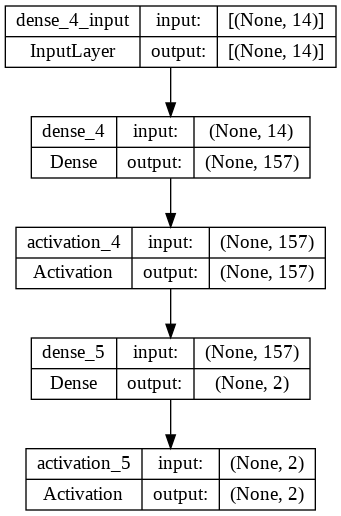

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
checkpoint_filepath = dataPath+'/nn_svm_new_9-11/checkpoints/MLP/'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss', #'val_accuracy'
    mode='min',
    save_best_only=True)

# v 69.138% train, el resto de validación (16.1%) del total de datos
epochs = 100 #50

training = model.fit(x_train, y_train, validation_split=0.15, batch_size=50, epochs=epochs, callbacks=[model_checkpoint_callback])# batch_size=32 , epochs=epochs) #batch_size= 20 para que sean 8 pasos por epoch porque son 257 imágenes de train = 257/20 = 12.85


model.load_weights(checkpoint_filepath)

Epoch 1/100
342/342 [==============================] - 2s 3ms/step - loss: 0.6168 - accuracy: 0.6962 - val_loss: 0.4554 - val_accuracy: 0.7836
Epoch 2/100
342/342 [==============================] - 2s 5ms/step - loss: 0.5271 - accuracy: 0.7520 - val_loss: 0.5058 - val_accuracy: 0.7156
Epoch 3/100
342/342 [==============================] - 1s 4ms/step - loss: 0.5192 - accuracy: 0.7567 - val_loss: 0.5617 - val_accuracy: 0.6595
Epoch 4/100
342/342 [==============================] - 1s 3ms/step - loss: 0.5158 - accuracy: 0.7594 - val_loss: 0.6922 - val_accuracy: 0.5855
Epoch 5/100
342/342 [==============================] - 2s 5ms/step - loss: 0.5105 - accuracy: 0.7639 - val_loss: 0.6569 - val_accuracy: 0.6140
Epoch 6/100
342/342 [==============================] - 2s 5ms/step - loss: 0.5148 - accuracy: 0.7607 - val_loss: 0.7246 - val_accuracy: 0.5712
Epoch 7/100
342/342 [==============================] - 1s 4ms/step - loss: 0.5150 - accuracy: 0.7579 - val_loss: 0.6266 - val_accuracy: 0.6326

In [ ]:
#evaluation of the model
loss, accuracy = model.evaluate(x_test, y_test, verbose=2)
print('Model loss: %.2f, Accuracy: %.2f' % ((loss*100),(accuracy*100)))

111/111 - 0s - loss: 0.5638 - accuracy: 0.7075 - 300ms/epoch - 3ms/step
Model loss: 56.38, Accuracy: 70.75


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


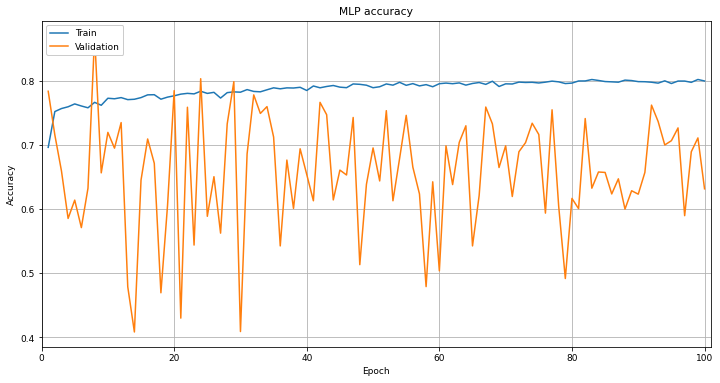

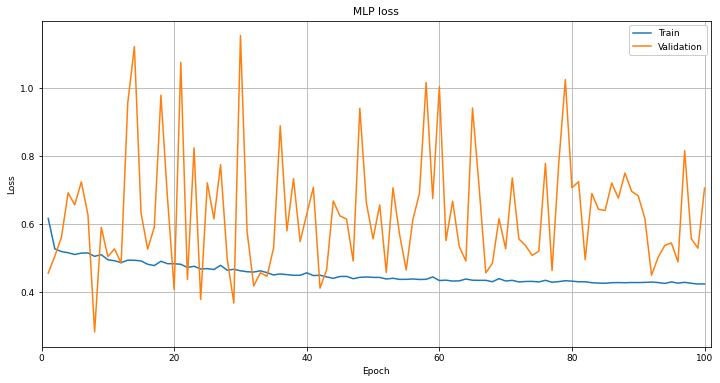

In [ ]:
# list all data in history
print(training.history.keys())
#print(history.history['accuracy'])

# summarize history for accuracy
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, epochs+1, 1), training.history['accuracy'])
plt.plot(np.arange(1, epochs+1, 1), training.history['val_accuracy'])
#plt.plot(np.arange(1, epochs+1, 1), model_history.history['val_accuracy'])
#plt.xticks(np.arange(1, epochs+1, 1), list(range(1, epochs+1)))
plt.xlim([0, epochs+1])
plt.title('MLP accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', framealpha=1)
plt.grid()
plt.show()

# summarize history for loss
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, epochs+1, 1), training.history['loss'])
plt.plot(np.arange(1, epochs+1, 1), training.history['val_loss'])
#plt.plot(np.arange(1, epochs+1, 1), model_history.history['val_loss'])
#plt.xticks(np.arange(1, epochs+1, 1), list(range(1, epochs+1)))
plt.xlim([0, epochs+1])
plt.title('MLP loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right', framealpha=1)#, fancybox=True)
plt.grid()
plt.show()

#plt.savefig('01_DenseNet121_DFV.jpg', dpi=200)

#-----------------------------------------------------------

In [ ]:
from matplotlib import pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=12)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=12)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.grid(False)

In [ ]:
y_pred = model.predict(x_test)

y_test_decoded = y_test.argmax(axis=1)
y_pred_decoded = y_pred.argmax(axis=1)


cm = confusion_matrix(y_test_decoded, y_pred_decoded)
print(cm)

#cm = confusion_matrix(model.predict(x_test), y_test)
#cm_plot_labels = ['Abnormal', 'Normal']
#plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='MLP Confusion Matrix (Test)')

In [ ]:
cm_plot_labels = ['Abnormal', 'Normal']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='MLP Confusion Matrix (Test)')

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

print('Accuracy MLP (Test): ',accuracy_score(y_test_decoded, y_pred_decoded))
print('Recall MLP (Test): ',recall_score(y_test_decoded, y_pred_decoded))
print('Precision MLP (Test): ',precision_score(y_test_decoded, y_pred_decoded))
print('F1 Score MLP (Test): ',f1_score(y_test_decoded, y_pred_decoded))

In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score
fpr, tpr, thresholds = roc_curve (y_test_decoded, y_pred_decoded)
auc_score=roc_auc_score(y_test_decoded,y_pred_decoded)

def plot_roc_curve(fpr, tpr):
  fig, ax = plt.subplots(figsize=(8, 6))
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' %auc_score)
  plt.axis([0,1,0,1])
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlabel('False Positive Rate', fontsize=12)
  plt.ylabel('True Positive Rate', fontsize=12)
  plt.title('Receiver Operating Characteristic Curve', fontsize=12)
  plt.legend(loc="lower right", fontsize=12)
  plt.show()

plot_roc_curve (fpr, tpr)

# SVM

In [ ]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', probability=True)  #kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’

y_train_decoded = y_train.argmax(axis=1)

svclassifier.fit(x_train, y_train_decoded)

#y_pred = svclassifier.predict(testX)

from sklearn.metrics import classification_report, confusion_matrix
print(svclassifier.score(x_train, y_train_decoded))
#print(confusion_matrix(y_pred,testY))
print(confusion_matrix(svclassifier.predict(x_train), y_train_decoded))
#print(classification_report(testY,y_pred))
print(len(x_train))

In [ ]:
y_pred_svm = svclassifier.predict(x_test)

#y_test_decoded = y_test.argmax(axis=1)
#y_pred_decoded = y_pred.argmax(axis=1)

cm = confusion_matrix(y_test_decoded, y_pred_svm)
print(cm)


In [ ]:
cm_plot_labels = ['Abnormal', 'Normal']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='SVM Confusion Matrix (Test)')

In [ ]:
print('Accuracy SVM (Test): ', accuracy_score(y_test_decoded, y_pred_svm))
print('Recall SVM (Test): ', recall_score(y_test_decoded, y_pred_svm))
print('Precision SVM (Test): ', precision_score(y_test_decoded, y_pred_svm))
print('F1 Score SVM (Test): ', f1_score(y_test_decoded, y_pred_svm))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_decoded, y_pred_svm))

In [ ]:
fpr, tpr, thresholds = roc_curve (y_test_decoded, y_pred_svm)
auc_score=roc_auc_score(y_test_decoded,y_pred_svm)

def plot_roc_curve(fpr, tpr):
  fig, ax = plt.subplots(figsize=(8, 6))
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' %auc_score)
  plt.axis([0,1,0,1])
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlabel('False Positive Rate', fontsize=12)
  plt.ylabel('True Positive Rate', fontsize=12)
  plt.title('Receiver Operating Characteristic Curve', fontsize=12)
  plt.legend(loc="lower right", fontsize=12)
  plt.show()

plot_roc_curve (fpr, tpr)

## ------------------------------------

In [ ]:
test_image = cv2.imread(ab_patches_test_path+'mdb001_patch1.png', 0)
#test_image = cv2.resize(test_image, (64,64))
plt.figure(figsize=(3, 3))
plt.imshow(test_image, cmap='gray')
plt.show()

x_features = extract_features_one_image(test_image)
x_features = pd.DataFrame(x_features).T
#x_features = x_features.fillna(value=0.0)
#x_features = x_features.T
#x_features = np.array(x_features)
#x_features = x_features.reshape(1,-1)
#x_features = scaler.transform(x_features)
#display(x_features)
print(x_features)
y_pred = svclassifier.predict(x_features)
y_pred_proba = svclassifier.predict_proba(x_features)
print('\nPrediction: ',y_pred)
print('\nPrediction proba: ',y_pred_proba)

print(max(y_pred_proba.max(axis=1)))

if max(y_pred_proba.max(axis=1))>=0.9:
  print("Es anormal y pasó el umbral de rechazo")
else:
  print("Es anormal pero no pasó el umbral de rechazo")


print('\n Prueba:', max(y_pred_proba.max(axis=1)), y_pred_proba.argmax(axis=1))

In [ ]:
##########################################################################################

In [ ]:
test_path = dataPath+'/01_allmias_mat_proc_eq/'
#test_image = cv2.imread(abnormal_train_path+'mdb219_output.png', 0)
test_image = cv2.imread(test_path+'mdb099_output.png', 0) #213 #La que está mostrada es la 205
#test_image = cv2.resize(test_image, (256, 256))

plt.figure(figsize=(8, 8))
plt.imshow(test_image, cmap='gray')
plt.show()

In [ ]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [ ]:
stepSize = 8
winH = 64
winW = 64
windowSize = (winH, winW)
clone = test_image.copy()
clone2 = cv2.cvtColor(clone, cv2.COLOR_GRAY2RGB)
for (x, y, window) in sliding_window(test_image, stepSize, windowSize):
    # if the current window does not meet our desired window size, ignore it
    if window.shape[0] != winH or window.shape[1] != winW:
      continue

    # PROCESS WINDOW, EXTRACT FEATURES
    window = test_image[y:y + windowSize[1], x:x + windowSize[0]]
    feats_window = extract_features_one_image(window)
    feats_window_df = pd.DataFrame(feats_window).T
    #y_pred = svclassifier.predict(feats_window_df)
    y_pred_proba = svclassifier.predict_proba(feats_window_df)
    if y_pred_proba.argmax(axis=1) == 0 and y_pred_proba.max(axis=1) >= 0.8: #Umbral de rechazo
      #print('y_pred_proba: ', y_pred_proba)
      cv2.rectangle(clone2, (x, y), (x + winW, y + winH), (255,0,0), 2)
    #clone = test_image.copy()
    #cv2.rectangle(clone, (x, y), (x + winW, y + winH), (255), 2)
    #cv2.imshow("Window", clone)
#clone = cv2.cvtColor(clone, cv2.COLOR_GRAY2RGB)
plt.figure(figsize=(8, 8))
plt.imshow(clone2)#, cmap='gray')
plt.show()

#Ojo: Coger los patches, el de menor tamaño volverlo el tamaño de patch estándar
#y a los paches que ya están que sean de mayor dimensión, sacarle patches del tamaño del más pequeño